In [1]:
import os
import psycopg2
from dotenv import load_dotenv

load_dotenv()

# make sure we can connect before running anything
try:
    conn = psycopg2.connect(os.getenv("DATABASE_URL"))
    cursor = conn.cursor()
    cursor.execute("SELECT version();")
    print("✓ Connected to:", cursor.fetchone()[0])
    cursor.close()
    conn.close()
except Exception as e:
    print("✗ Connection failed:", e)

✓ Connected to: PostgreSQL 17.6 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit


In [2]:
import sys
print(sys.executable)

c:\Users\kdevu\AppData\Local\Python\pythoncore-3.14-64\python.exe


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# reuse this instead of repeating the connection string everywhere
def get_connection():
    return psycopg2.connect(os.getenv("DATABASE_URL"))

# consistent styling across all charts
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4

print("✓ Setup complete")

✓ Setup complete


C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\4012923716.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, parse_dates=["month"])


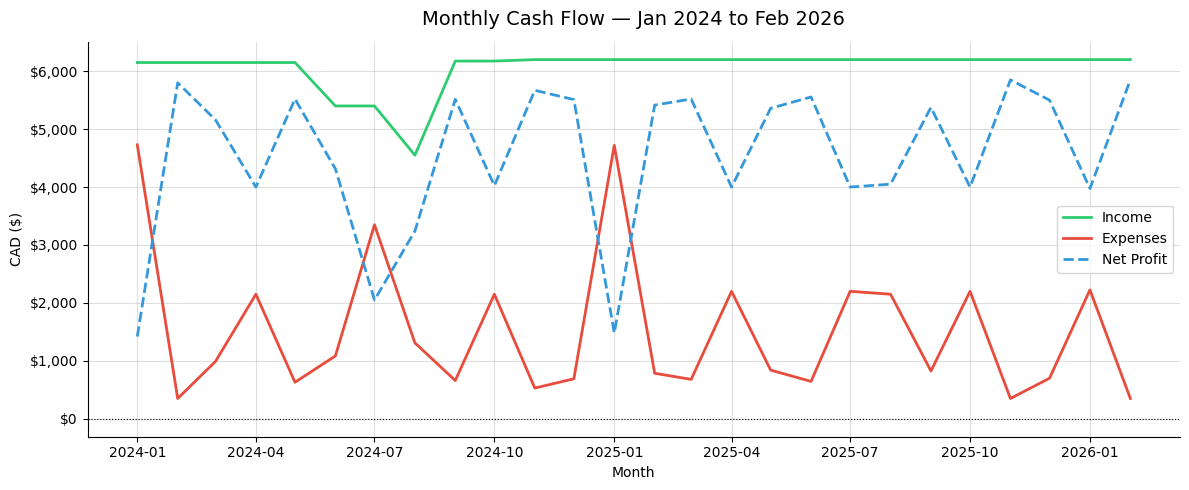

In [4]:
# --- Monthly Cash Flow ---
# rent collected vs expenses per month, and the net result
# income and expenses live in separate tables so we sum each one by month
# first (CTEs), then join on month — FULL OUTER so we don't drop any months

query = """
    WITH monthly_income AS (
        SELECT
            DATE_TRUNC('month', payment_date) AS month,
            SUM(amount)                       AS total_income
        FROM payments
        WHERE status IN ('on_time', 'late')
        GROUP BY 1
    ),
    monthly_expenses AS (
        SELECT
            DATE_TRUNC('month', expense_date) AS month,
            SUM(amount)                       AS total_expenses
        FROM expenses
        GROUP BY 1
    )
    SELECT
        COALESCE(i.month, e.month)                                    AS month,
        COALESCE(i.total_income, 0)                                   AS total_income,
        COALESCE(e.total_expenses, 0)                                 AS total_expenses,
        COALESCE(i.total_income, 0) - COALESCE(e.total_expenses, 0)  AS net_profit
    FROM monthly_income AS i
    FULL OUTER JOIN monthly_expenses AS e ON i.month = e.month
    ORDER BY month
"""

conn = get_connection()
df = pd.read_sql(query, conn, parse_dates=["month"])
conn.close()

fig, ax = plt.subplots()

ax.plot(df["month"], df["total_income"],   label="Income",     color="#2ecc71", linewidth=2)
ax.plot(df["month"], df["total_expenses"], label="Expenses",   color="#e74c3c", linewidth=2)
ax.plot(df["month"], df["net_profit"],     label="Net Profit", color="#3498db", linewidth=2, linestyle="--")

# reference line so loss months are easy to spot
ax.axhline(0, color="black", linewidth=0.8, linestyle=":")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
ax.set_title("Monthly Cash Flow — Jan 2024 to Feb 2026", fontsize=14, pad=12)
ax.set_xlabel("Month")
ax.set_ylabel("CAD ($)")
ax.legend()

plt.tight_layout()
plt.show()

C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\460723174.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


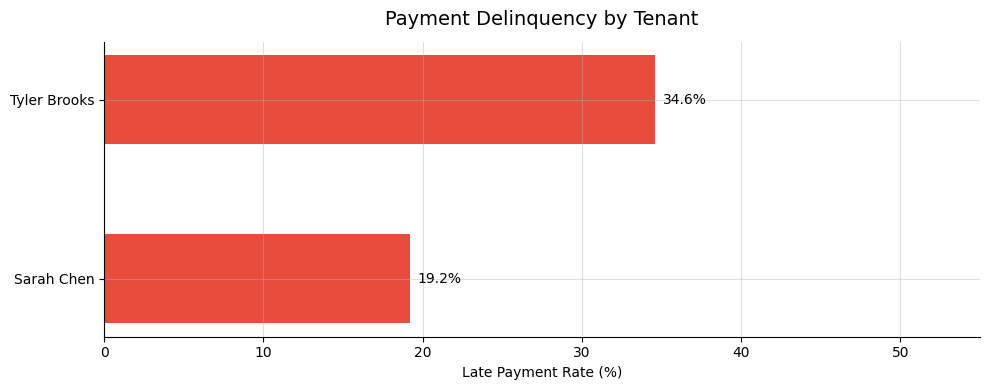

In [5]:
# --- Payment Delinquency by Tenant ---
# who pays late and how often — only showing tenants with at least one late payment
# moved the filter into SQL with HAVING so we're not doing it in python after

query = """
    SELECT
        t.first_name || ' ' || t.last_name        AS tenant,
        COUNT(*) FILTER (WHERE p.status = 'late') AS late_payments,
        ROUND(
            COUNT(*) FILTER (WHERE p.status = 'late') * 100.0 / COUNT(*), 1
        )                                          AS late_rate_pct
    FROM payments AS p
    JOIN leases  AS l ON p.lease_id  = l.lease_id
    JOIN tenants AS t ON l.tenant_id = t.tenant_id
    GROUP BY t.tenant_id, t.first_name, t.last_name
    HAVING COUNT(*) FILTER (WHERE p.status = 'late') > 0
    ORDER BY late_rate_pct DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

fig, ax = plt.subplots(figsize=(10, 4))

ax.barh(df["tenant"], df["late_rate_pct"], color="#e74c3c", height=0.5)

for i, val in enumerate(df["late_rate_pct"]):
    ax.text(val + 0.5, i, f"{val}%", va="center", fontsize=10)

ax.set_xlim(0, 55)
ax.set_xlabel("Late Payment Rate (%)")
ax.set_title("Payment Delinquency by Tenant", fontsize=14, pad=12)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [6]:
# --- Vacancy Analysis ---
# gaps between leases — how long each unit sat empty and what it cost
# LEAD() grabs the next lease's start date per unit so we can subtract

query = """
    WITH lease_gaps AS (
        SELECT
            u.unit_label,
            l.end_date AS lease_end,
            LEAD(l.start_date) OVER (
                PARTITION BY l.unit_id ORDER BY l.start_date
            ) AS next_lease_start,
            l.monthly_rent
        FROM leases AS l
        JOIN units  AS u ON l.unit_id = u.unit_id
    )
    SELECT
        unit_label,
        lease_end,
        next_lease_start,
        (next_lease_start - lease_end)                               AS vacancy_days,
        ROUND((next_lease_start - lease_end) * (monthly_rent / 30.0), 2) AS est_lost_rent
    FROM lease_gaps
    WHERE next_lease_start IS NOT NULL
    ORDER BY vacancy_days DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

df["est_lost_rent"] = df["est_lost_rent"].apply(lambda x: f"${x:,.2f}")

print("Vacancy Gaps Between Leases\n")
print(df.to_string(index=False))

Vacancy Gaps Between Leases

unit_label  lease_end next_lease_start  vacancy_days est_lost_rent
        R5 2024-05-31       2024-09-01            93     $2,325.00
        R3 2024-10-31       2024-11-01             1        $28.33


C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\2196353254.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\3190665884.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


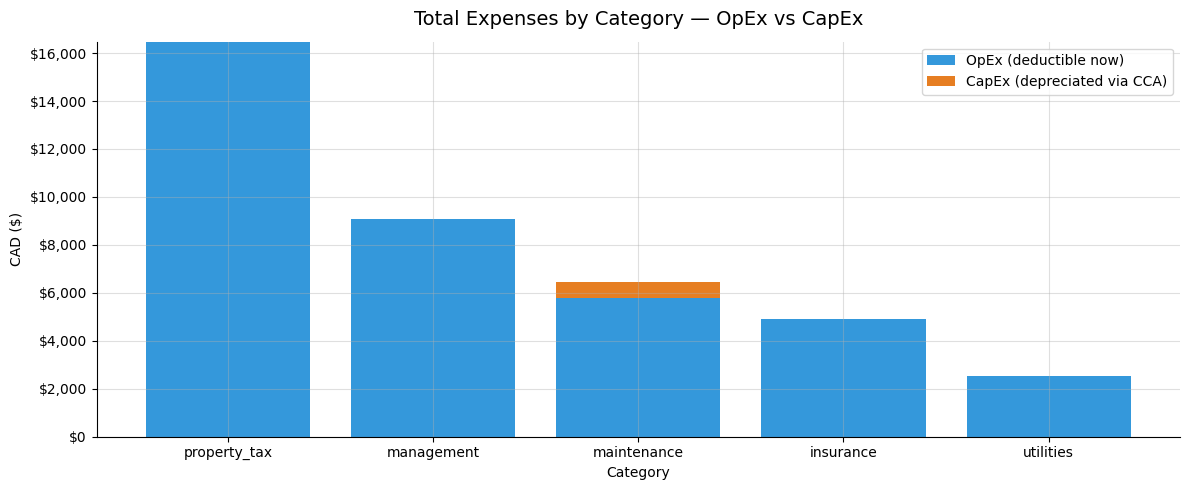

In [7]:
# --- Expense Breakdown by Category ---
# where did the money go, and how much is tax-deductible this year?
# opex = deducted now, capex = depreciated over years via CCA
# the orange slice on maintenance is the R5 fridge replacement ($680)

query = """
    SELECT
        category,
        SUM(amount) AS total_spent,
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'opex'), 0)  AS total_opex,
        COALESCE(SUM(amount) FILTER (WHERE expense_class = 'capex'), 0) AS total_capex
    FROM expenses
    GROUP BY category
    HAVING SUM(amount) > 0
    ORDER BY total_spent DESC
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

fig, ax = plt.subplots()

ax.bar(df["category"], df["total_opex"],  label="OpEx (deductible now)",     color="#3498db")
ax.bar(df["category"], df["total_capex"], label="CapEx (depreciated via CCA)",
       color="#e67e22", bottom=df["total_opex"])

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
ax.set_title("Total Expenses by Category — OpEx vs CapEx", fontsize=14, pad=12)
ax.set_xlabel("Category")
ax.set_ylabel("CAD ($)")
ax.legend()

plt.tight_layout()
plt.show()

In [8]:
# --- Rent Roll ---
# current snapshot — who's in each unit, what they pay, when they started
# lease_end = None means open-ended (month-to-month)

query = """
    SELECT
        u.unit_label,
        t.first_name || ' ' || t.last_name AS tenant,
        l.monthly_rent,
        l.start_date                        AS lease_start,
        l.end_date                          AS lease_end,
        (CURRENT_DATE - l.start_date) / 30  AS months_tenanted,
        l.security_deposit
    FROM units   AS u
    JOIN leases  AS l ON u.unit_id   = l.unit_id
    JOIN tenants AS t ON l.tenant_id = t.tenant_id
    WHERE l.status = 'active'
    ORDER BY u.unit_label
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

df["monthly_rent"]     = df["monthly_rent"].apply(lambda x: f"${x:,.2f}")
df["security_deposit"] = df["security_deposit"].apply(lambda x: f"${x:,.2f}")

print("Current Rent Roll\n")
print(df.to_string(index=False))

Current Rent Roll

unit_label          tenant monthly_rent lease_start lease_end  months_tenanted security_deposit
        R1    James Wilson      $750.00  2024-01-01      None               26          $750.00
        R2      Sarah Chen      $800.00  2024-01-01      None               26          $800.00
        R3    Lucas Nguyen      $875.00  2024-11-01      None               16          $875.00
        R4 Emily Rodriguez      $700.00  2024-01-01      None               26          $700.00
        R5 Olivia Tremblay      $775.00  2024-09-01      None               18          $775.00
        R6     Priya Patel      $900.00  2024-01-01      None               26          $900.00
        R7    Tyler Brooks      $750.00  2024-01-01      None               26          $750.00
        R8   Aisha Mahmoud      $650.00  2024-01-01      None               26          $650.00


C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\589110021.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\kdevu\AppData\Local\Temp\ipykernel_35028\1903290147.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


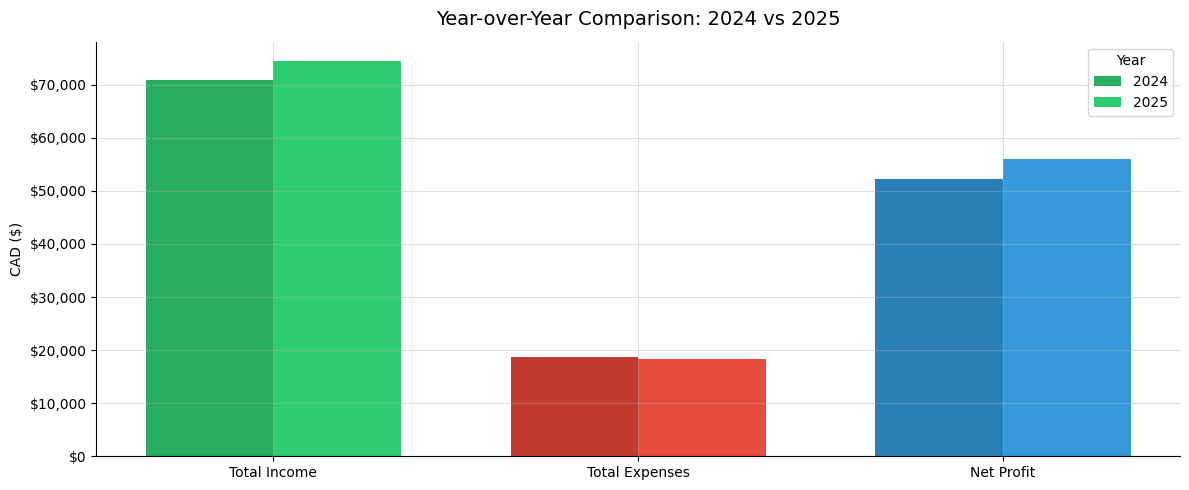

In [9]:
# --- Year-over-Year Comparison: 2024 vs 2025 ---
# 2026 excluded — only Jan-Feb data so it's not a fair comparison

query = """
    WITH yearly_income AS (
        SELECT
            EXTRACT(year FROM payment_date) AS year,
            SUM(amount)                     AS total_income
        FROM payments
        WHERE status IN ('on_time', 'late')
          AND EXTRACT(year FROM payment_date) IN (2024, 2025)
        GROUP BY 1
    ),
    yearly_expenses AS (
        SELECT
            EXTRACT(year FROM expense_date) AS year,
            SUM(amount)                     AS total_expenses
        FROM expenses
        WHERE EXTRACT(year FROM expense_date) IN (2024, 2025)
        GROUP BY 1
    )
    SELECT
        i.year,
        i.total_income,
        e.total_expenses,
        i.total_income - e.total_expenses AS net_profit
    FROM yearly_income   AS i
    JOIN yearly_expenses AS e ON i.year = e.year
    ORDER BY i.year
"""

conn = get_connection()
df = pd.read_sql(query, conn)
conn.close()

row_2024 = df[df["year"] == 2024].iloc[0]
row_2025 = df[df["year"] == 2025].iloc[0]

categories = ["Total Income", "Total Expenses", "Net Profit"]
vals_2024  = [row_2024["total_income"], row_2024["total_expenses"], row_2024["net_profit"]]
vals_2025  = [row_2025["total_income"], row_2025["total_expenses"], row_2025["net_profit"]]

x     = [0, 1, 2]
width = 0.35

fig, ax = plt.subplots()

ax.bar([i - width/2 for i in x], vals_2024, width, label="2024", color=["#27ae60", "#c0392b", "#2980b9"])
ax.bar([i + width/2 for i in x], vals_2025, width, label="2025", color=["#2ecc71", "#e74c3c", "#3498db"])

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"${v:,.0f}"))
ax.set_title("Year-over-Year Comparison: 2024 vs 2025", fontsize=14, pad=12)
ax.set_ylabel("CAD ($)")
ax.legend(title="Year")

plt.tight_layout()
plt.show()